## Header Code

In [44]:
%matplotlib inline
import numpy as np
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import discrete
import re
import pandas as pd
import math 
import csv
import time
import dateutil
from datetime import datetime
import seaborn as sns

from IPython.core.display import HTML
HTML("<style>.container {width:80% !important; }</style>")

In [2]:
# pandas options plus some more
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.options.display.float_format = '{:,.3f}'.format
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
# Matplotlib Formatting
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import ticker


millnames = ['',' Thousand',' Million',' Billion',' Trillion']
def millify(n, pos):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    thingtoreturn = n / 10**(3 * millidx)
    if thingtoreturn % 1 == 0:
        return '{:.0f}{}'.format(thingtoreturn, millnames[millidx])
    elif thingtoreturn % 0.1 == 0:
        return '{:.1f}{}'.format(thingtoreturn, millnames[millidx])
    else:
        return '{:.2f}{}'.format(thingtoreturn, millnames[millidx])

## Pre-load

**Municipal Codes**

** load necessary datasets **

In [4]:
# municipal codes
municipal_codes_df = pd.read_excel("./exports/Municipal Code Matching.xlsx")

# political party classification
partydf = pd.read_csv("./Political Party Switches/party_classifications.csv")

# incomes
incomesdf = pd.read_csv("./exports/incomesdf.csv")

# budgets
budgetsdf = pd.read_csv("./exports/budgetsdf.csv")

# panels data
apaneldf = pd.read_csv("./exports/apaneldf.csv")
mpaneldf = pd.read_csv("./exports/mpaneldf.csv")

# development categories
developmentdf = pd.read_csv("./General Info/development_categories.csv")

# convert date to years in int
apaneldf.date = apaneldf.date.str.replace("-\d\d-\d\d","").astype(int)
mpaneldf.date = pd.to_datetime(mpaneldf.date)

In [5]:
budgetsdf.mun.nunique()
incomesdf.mun.nunique()
apaneldf.in_gov11.unique()

array([0, 1], dtype=int64)

# Reshaping Data

## Cross Period

### Transfers 

#### Shares

In [6]:
# get total transfers by year
transfers = incomesdf[incomesdf.l6_name_english == 'Transfers from other level of government'].copy()
transfers_munyeardf = transfers.groupby(["mun_id","year"]).sum().drop(["l2","l4","l3","l6"], axis=1).unstack(level=1)
transfers_munyeardf.drop("Unnamed: 0", axis=1, inplace=1)

#normalize
norm_transfers_munyeardf = pd.DataFrame()

for col in transfers_munyeardf.columns:
    transfers_munyeardf["share_" + col[0] + str(col[1])] = (transfers_munyeardf[col] / transfers_munyeardf[col].sum()).copy()

def change(df):
    x11 = df[('income_value',2011)] == 0
    x13 = df[('income_value',2013)] == 0
    if x11 & x13:
        return 0    
    if  ~x11 & x13:
        return -1
    if x11 &  ~x13:
        return 2
    else:
        return ((df[('income_value',2013)] - df[('income_value',2011)])/df[('income_value',2011)]).copy()

#find 2011, 2013 difference
share_change = pd.DataFrame()
share_change["norm_percent_change"] = transfers_munyeardf.apply(change, axis=1) * 100
transfers_munyeardf["norm_percent_change"] = share_change["norm_percent_change"]

### Politics

#### 2011-2013'

In [7]:
def gov_change(df):
    if np.isnan(df["ingov11"])  | np.isnan(df["ingov13"]):
        return np.nan
    
    if (df["ingov11"] != 1) & (df["ingov13"] != 1):
        return "3unaligned both years"
    
    if (df["ingov11"] == 1) & (df["ingov13"] == 1):
        return "2aligned both years"
    
    if (df["ingov11"] != 1) & (df["ingov13"] == 1):
        return "1became aligned"
    
    if (df["ingov11"] == 1) & (df["ingov13"] != 1):
        return "4stopped being aligned"
    
share_change["ingov11"] = apaneldf[apaneldf.date == 2011].set_index("mun_id").in_gov11.copy()
share_change["ingov13"] = apaneldf[apaneldf.date == 2013].set_index("mun_id").ingov13.copy()
share_change["opo11"] = apaneldf[apaneldf.date == 2011].set_index("mun_id").opo11.copy()
share_change["opo13"] = apaneldf[apaneldf.date == 2013].set_index("mun_id").opo13.copy()

share_change["gov_change"] = share_change.apply(gov_change, axis=1)

share_change["mun"] = municipal_codes_df.set_index("mun_id").mun
share_change.sort_values("norm_percent_change", ascending=0, inplace=1)


In [8]:
share_change.gov_change = share_change.gov_change.astype("category")
share_change.gov_change.unique().reorder_categories(["1became aligned","2aligned both years",
                                                     "3unaligned both years","4stopped being aligned"], ordered=True)


share_change.to_csv("./exports/2011_to_2013.csv")

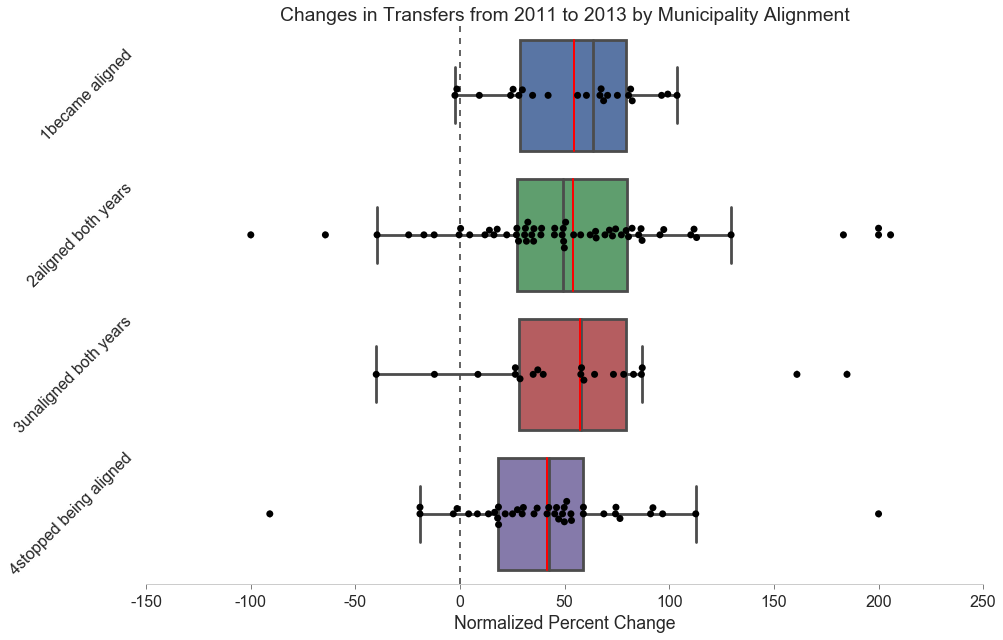

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millify))

# rotate x labels
locs, labels = plt.yticks()
plt.setp(labels, rotation=45);
plt.grid()

plt.axvline(0,color='black',alpha=.6,ls='dashed',lw=2)
sns.swarmplot("norm_percent_change", "gov_change" ,data=share_change.dropna(), color='black', size=7)
sns.boxplot("norm_percent_change", "gov_change" ,data=share_change.dropna(),
            meanprops={'linewidth':2, 'color':'red'}, meanline=1, showmeans=1)

title = "Changes in Transfers from 2011 to 2013 by Municipality Alignment"
subtitle = "Depending on alignment with national coalition pre and after 2012 election"
plt.title(title)

# axes options
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x',which='major', direction='out', width=1,length=5,bottom='on',top="off",color='grey')

ax.set_ylabel("")

ax.set_xlabel("Normalized Percent Change")

plt.savefig("./exports/figures/" + title, bbox_inches='tight')

#### 2012-2013'

In [10]:
# pre 2012 election

# get who was in power 6 months prior to election in 2012
paneldf_pre2012 = mpaneldf[(pd.to_datetime("2011-12-30") < mpaneldf.date ) & (mpaneldf.date < pd.to_datetime("2012-05-01"))]

# get parties who were longest in power during this period
inpower_2012_df = paneldf_pre2012.groupby('mun_id').party_id.agg(lambda x:x.value_counts().index[0])
inpower_2012_df = pd.DataFrame(inpower_2012_df).reset_index()

inpower_2012_df = inpower_2012_df.merge(partydf[["name_full","in_gov12", "party_id"]], on='party_id', how='left')
inpower_2012_df.columns = ["mun_id", "party_id_12", "name_full_12","in_gov12"]

In [11]:
# get total transfers by year
transfers = incomesdf[incomesdf.l6_name_english == 'Transfers from other level of government'].copy()
transfers_munyeardf = transfers.groupby(["mun_id","year"]).sum().drop(["l2","l4","l3","l6"], axis=1).unstack(level=1)
transfers_munyeardf.drop("Unnamed: 0", axis=1, inplace=1)

#normalize
norm_transfers_munyeardf = pd.DataFrame()

for col in transfers_munyeardf.columns:
    transfers_munyeardf["share_" + col[0] + str(col[1])] = (transfers_munyeardf[col] / transfers_munyeardf[col].sum()).copy()

def change(df):
    x12 = df[('income_value',2012)] == 0
    x13 = df[('income_value',2013)] == 0
    if x12 & x13:
        return 0    
    if  ~x12 & x13:
        return -1
    if x12 &  ~x13:
        return 2
    else:
        return ((df[('income_value',2013)] - df[('income_value',2012)])/df[('income_value',2012)]).copy()

#find 2011, 2013 difference
share_change12_13 = pd.DataFrame()
share_change12_13["norm_percent_change12_13"] = transfers_munyeardf.apply(change, axis=1) * 100
transfers_munyeardf["norm_percent_change12_13"] = share_change12_13["norm_percent_change12_13"]

In [12]:
def gov_change(df):
    if np.isnan(df["ingov12"])  | np.isnan(df["ingov13"]):
        return np.nan
    
    if (df["ingov12"] != 1) & (df["ingov13"] != 1):
        return "3unaligned both years12_13"
    
    if (df["ingov12"] == 1) & (df["ingov13"] == 1):
        return "2aligned both years12_13"
    
    if (df["ingov12"] != 1) & (df["ingov13"] == 1):
        return "1became aligned12_13"
    
    if (df["ingov12"] == 1) & (df["ingov13"] != 1):
        return "4stopped being aligned12_13"
    
    
share_change12_13["ingov12"] = inpower_2012_df.set_index("mun_id").in_gov12
share_change12_13["ingov13"] = apaneldf[apaneldf.date == 2013].set_index("mun_id").ingov13.copy()


share_change12_13["gov_change12_13"] = share_change12_13.apply(gov_change, axis=1)

share_change12_13["mun"] = municipal_codes_df.set_index("mun_id").mun
share_change12_13.sort_values("norm_percent_change12_13", ascending=0, inplace=1)


In [13]:
share_change12_13.gov_change12_13 = share_change12_13.gov_change12_13.astype("category")
share_change12_13.gov_change12_13.unique().reorder_categories(["1became aligned12_13","2aligned both years12_13",
                                                     "3unaligned both years12_13","4stopped being aligned12_13"], ordered=True)


share_change12_13.to_csv("./exports/2012_to_2013.csv")

## Within period

In [14]:
l6income = pd.read_csv("./exports/l6income_by_yeardf.csv")
l6income11 = l6income[l6income.year == 2011][["mun_id","Transfers from other level of government",
                                              u'Taxes on income, profits and capital gains ']]

l6income12 = l6income[l6income.year == 2012][["mun_id","Transfers from other level of government",
                                             u'Taxes on income, profits and capital gains ']]

l6income13 = l6income[l6income.year == 2013][["mun_id","Transfers from other level of government",
                                             u'Taxes on income, profits and capital gains ']]


##  Alignmentdf and Controls

In [15]:
# add controls
demdf = pd.read_csv("./exports/demdf.csv")
controls = demdf[[ 'mun_id', 'mun_type','area_km2','pop_total','labor_pariticpation_rate',
                  'wage_2012', 'wage_2011','wage_2013','employment_rate']]

# add two prior datasets with changes in gov and share
test = share_change.dropna().merge(controls, left_index=1, right_on="mun_id")
test = test.merge(share_change12_13.reset_index(), on="mun_id")

# add development categories
test = test.merge(developmentdf, on="mun_id")

# get dummies and for different alignments & constant
alignmentdf = pd.get_dummies(test, prefix="dummy", columns=["gov_change","gov_change12_13",'mun_type', 'cat_dev_10']).dropna()
alignmentdf["constant"] = 1

# add income taxes per capita
alignmentdf = alignmentdf.merge(l6income12[["mun_id",'Taxes on income, profits and capital gains ']], on="mun_id")
alignmentdf.set_index("mun_id",inplace=1)
alignmentdf["Tax_Income_per_Capita"] = alignmentdf['Taxes on income, profits and capital gains '] / alignmentdf.pop_total

# add absolute change in transfers
alignmentdf['absolute_change_transfers'] = transfers_munyeardf[('income_value',2013)] - transfers_munyeardf[('income_value',2011)]

# add log population control option
alignmentdf['log_pop_total'] = np.log(alignmentdf['pop_total'])
alignmentdf.reset_index(inplace=1)

#remove outliers with faulty data (reported 0 transfers when in fact it wasn't 0)
alignmentdf.drop(alignmentdf[alignmentdf.mun_x.apply(lambda x: x in ["Vladimirci", "Bojnik", "Lebane", "Vladicin Han", "Grad Beograd"])].index, inplace=1)
share_change.to_csv("./exports/changesdf.csv")

# add who was in power in 2012
alignmentdf = alignmentdf.merge(inpower_2012_df, how='left', on='mun_id')

alignmentdf = alignmentdf[['norm_percent_change',"norm_percent_change12_13", 'ingov11', 'ingov12', 'ingov13_x', 'mun', 'opo11', 'opo13',
                           'mun_id','wage_2011','wage_2013', "party_id_12", "name_full_12", 
                           'pop_total', 'log_pop_total', 
                           'dummy_1became aligned','dummy_3unaligned both years', 'dummy_4stopped being aligned', 'dummy_2aligned both years',
                           'dummy_1became aligned12_13','dummy_3unaligned both years12_13', 'dummy_4stopped being aligned12_13', 'dummy_2aligned both years12_13',
                           "dummy_one", "dummy_two", "dummy_four", "dummy_devastated",
                           "Tax_Income_per_Capita",'area_km2','wage_2012',"constant",
                           'employment_rate','labor_pariticpation_rate','dummy_city','dummy_normal','absolute_change_transfers']]

alignmentdf.set_index("mun_id").to_csv("./exports/regressions/alignmentchangevsnormpercentchange.csv")

In [16]:
share_change.to_csv("./exports/changesdf.csv")

# Regressions

## Controls: Log Population

We control for log population because of the below relationships:

<script type='text/javascript' src='https://public.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1004px; height: 869px;'><noscript><a href='#'><img alt='Log Population Relationship ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Controls&#47;LogPopulationRelationship&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz' width='1004' height='869' style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='Controls&#47;LogPopulationRelationship' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Controls&#47;LogPopulationRelationship&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='showTabs' value='y' /></object></div>

In [17]:
#load dataset
alignmentdf = pd.read_csv("./exports/regressions/alignmentchangevsnormpercentchange.csv")

# include option for normal municipalities only
normalonly = alignmentdf[alignmentdf.dummy_normal == 1]

# import library for collinearity examination
from statsmodels.stats import outliers_influence as oi

### Cross Periods

#### 2011-2013

In [48]:
# regression 2011-2013
endogenous = "norm_percent_change"
exogenous = ["log_pop_total", "dummy_1became aligned", "dummy_3unaligned both years", "dummy_4stopped being aligned"]



align_cross_mod = sm.OLS(normalonly[endogenous],normalonly[exogenous])
align_cross_11_13_ols = align_cross_mod.fit()
print align_cross_11_13_ols.summary()

                             OLS Regression Results                            
Dep. Variable:     norm_percent_change   R-squared:                       0.569
Model:                             OLS   Adj. R-squared:                  0.556
Method:                  Least Squares   F-statistic:                     42.65
Date:                 Thu, 05 May 2016   Prob (F-statistic):           9.43e-23
Time:                         15:35:50   Log-Likelihood:                -689.56
No. Observations:                  133   AIC:                             1387.
Df Residuals:                      129   BIC:                             1399.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
log_po

In [49]:
# we look for the source of colinearity
exogenous = ["log_pop_total", "dummy_1became aligned", "dummy_3unaligned both years", "dummy_4stopped being aligned"]
exog = alignmentdf[exogenous].as_matrix()

for i in range(len(exogenous)):
    print exogenous[i] + ":", oi.variance_inflation_factor(exog,i)
    i += 1

log_pop_total: 2.356267195
dummy_1became aligned: 1.37471578984
dummy_3unaligned both years: 1.32447389187
dummy_4stopped being aligned: 1.65707751329


In [50]:
# robust regression 2011-2013
endogenous = "norm_percent_change"
exogenous = ["log_pop_total", "dummy_1became aligned", "dummy_3unaligned both years", "dummy_4stopped being aligned"]

rlm_model = sm.RLM(normalonly[endogenous],normalonly[exogenous], M=sm.robust.norms.HuberT())
align_cross_11_13_rlm = rlm_model.fit()
print align_cross_11_13_rlm.summary()

                     Robust linear Model Regression Results                    
Dep. Variable:     norm_percent_change   No. Observations:                  133
Model:                             RLM   Df Residuals:                      129
Method:                           IRLS   Df Model:                            3
Norm:                           HuberT                                         
Scale Est.:                        mad                                         
Cov Type:                           H1                                         
Date:                 Thu, 05 May 2016                                         
Time:                         15:35:50                                         
No. Iterations:                      9                                         
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
log_po

#### 2012-2013

In [51]:
# regression 2012-2013
endogenous = "norm_percent_change12_13"
exogenous = ["log_pop_total", "dummy_1became aligned12_13", "dummy_3unaligned both years12_13", "dummy_4stopped being aligned12_13"]



rlm_model = sm.RLM(normalonly[endogenous],normalonly[exogenous], M=sm.robust.norms.HuberT())
align_cross_12_13_rlm = rlm_model.fit()
print align_cross_12_13_rlm.summary()

                       Robust linear Model Regression Results                       
Dep. Variable:     norm_percent_change12_13   No. Observations:                  133
Model:                                  RLM   Df Residuals:                      129
Method:                                IRLS   Df Model:                            3
Norm:                                HuberT                                         
Scale Est.:                             mad                                         
Cov Type:                                H1                                         
Date:                      Thu, 05 May 2016                                         
Time:                              15:35:51                                         
No. Iterations:                          21                                         
                                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------

### Time slice Comparisons

#### 2011

In [52]:
# 2011 regression

# create needed dataframe
align_in11 = alignmentdf.merge(l6income11, on="mun_id")

# get per capita variables
align_in11['Transfers_per_Capita_11'] = align_in11['Transfers from other level of government'] / align_in11[u'pop_total']
align_in11['income_tax_per_capita'] = align_in11['Taxes on income, profits and capital gains '] / align_in11[u'pop_total']

# select necessary subset of dataframe
align_in11 = align_in11[[u'Transfers_per_Capita_11', u'opo11', u'area_km2', u'log_pop_total', 
                     u'labor_pariticpation_rate', 'income_tax_per_capita',
                     u'wage_2011', u'employment_rate', u'dummy_city', u'dummy_normal']]

# create dummies
align_in11 = pd.get_dummies(align_in11, prefix="dummy", columns=["opo11"]).dropna()

# run regression
endog = "Transfers_per_Capita_11"
exog =  ["log_pop_total","dummy_1.0", "dummy_-1.0"]

rlm_model = sm.RLM(align_in11[endog],align_in11[exog], M=sm.robust.norms.HuberT())
align_11_rlm = rlm_model.fit()
print align_11_rlm.summary()

                       Robust linear Model Regression Results                      
Dep. Variable:     Transfers_per_Capita_11   No. Observations:                  136
Model:                                 RLM   Df Residuals:                      133
Method:                               IRLS   Df Model:                            2
Norm:                               HuberT                                         
Scale Est.:                            mad                                         
Cov Type:                               H1                                         
Date:                     Thu, 05 May 2016                                         
Time:                             15:35:51                                         
No. Iterations:                          9                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------

This is an odd result. It would be one thing for the opposition to be *not discriminated* against, but there doesn't seem to be any possible theory explaining why the opposition would *favored*. This suggests there is a confounding effect which we are not controlling for. 

#### 2012

In [53]:
# 2012 regression

# create needed dataframe
align_in12 = alignmentdf.merge(l6income12, on="mun_id")

# get per capita variables
align_in12['Transfers_per_Capita_12'] = align_in12['Transfers from other level of government'] / align_in12[u'pop_total']
align_in12['income_tax_per_capita'] = align_in12['Taxes on income, profits and capital gains '] / align_in12[u'pop_total']

# select necessary subset of dataframe
align_in12 = align_in12[[u'Transfers_per_Capita_12', u'ingov12', u'area_km2', u'log_pop_total', 
                     u'labor_pariticpation_rate', 'income_tax_per_capita',
                     u'wage_2012', u'employment_rate', u'dummy_city', u'dummy_normal']]

# create dummies
align_in12 = pd.get_dummies(align_in12, prefix="dummy", columns=["ingov12"]).dropna()

# run regression
endog = "Transfers_per_Capita_12"
exog =  ["log_pop_total","dummy_1.0"]

rlm_model = sm.RLM(align_in12[endog],align_in12[exog], M=sm.robust.norms.HuberT())
align_12_rlm = rlm_model.fit()
print align_12_rlm.summary()

                       Robust linear Model Regression Results                      
Dep. Variable:     Transfers_per_Capita_12   No. Observations:                  136
Model:                                 RLM   Df Residuals:                      134
Method:                               IRLS   Df Model:                            1
Norm:                               HuberT                                         
Scale Est.:                            mad                                         
Cov Type:                               H1                                         
Date:                     Thu, 05 May 2016                                         
Time:                             15:35:51                                         
No. Iterations:                         12                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------

#### 2013

In [54]:
#2013 regression

# create needed dataframe
align_in13 = alignmentdf.merge(l6income13, on="mun_id")

# get per capita variables
align_in13['Transfers_per_Capita_13'] = align_in13['Transfers from other level of government'] / align_in13[u'pop_total']
align_in13['income_tax_per_capita'] = align_in13['Taxes on income, profits and capital gains '] / align_in13[u'pop_total']

# select necessary subset of dataframe
align_in13 = align_in13[[u'Transfers_per_Capita_13', u'opo13', u'area_km2', u'log_pop_total', 
                     u'labor_pariticpation_rate', 'income_tax_per_capita',
                     u'wage_2013', u'employment_rate', u'dummy_city', u'dummy_normal']]

# create dummies
align_in13 = pd.get_dummies(align_in13, prefix="dummy", columns=["opo13"]).dropna()

# run regression
endog = "Transfers_per_Capita_13"
exog =  ["log_pop_total","dummy_1.0", "dummy_-1.0"]

rlm_model = sm.RLM(align_in13[endog],align_in13[exog], M=sm.robust.norms.HuberT())
align_13_rlm = rlm_model.fit()
print align_13_rlm.summary()

                       Robust linear Model Regression Results                      
Dep. Variable:     Transfers_per_Capita_13   No. Observations:                  136
Model:                                 RLM   Df Residuals:                      133
Method:                               IRLS   Df Model:                            2
Norm:                               HuberT                                         
Scale Est.:                            mad                                         
Cov Type:                               H1                                         
Date:                     Thu, 05 May 2016                                         
Time:                             15:35:51                                         
No. Iterations:                         10                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------

## Controls: Log Population + Development Category

We include controls now for development category of the municipality. Development categories are one of the crucial determinants of levels of transfers to a municipality. As such, we try to improve our controls using them. 

<script type='text/javascript' src='https://public.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1004px; height: 869px;'><noscript><a href='#'><img alt='Development Categories Relationship ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Controls&#47;DevelopmentCategoriesRelationship&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz' width='1004' height='869' style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='Controls&#47;DevelopmentCategoriesRelationship' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Controls&#47;DevelopmentCategoriesRelationship&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='showTabs' value='y' /></object></div>

### Cross Periods

#### 2011-2013''

In [55]:
# regression 2011-2013
endogenous = "norm_percent_change"
exogenous = ["log_pop_total","dummy_one", "dummy_two", "dummy_four", "dummy_devastated", 
             "dummy_1became aligned", "dummy_3unaligned both years", "dummy_4stopped being aligned"]



rlm_model = sm.RLM(normalonly[endogenous],normalonly[exogenous], M=sm.robust.norms.HuberT())
align_cross_11_13_rlm_cntrls = rlm_model.fit()
print align_cross_11_13_rlm_cntrls.summary()

                     Robust linear Model Regression Results                    
Dep. Variable:     norm_percent_change   No. Observations:                  133
Model:                             RLM   Df Residuals:                      125
Method:                           IRLS   Df Model:                            7
Norm:                           HuberT                                         
Scale Est.:                        mad                                         
Cov Type:                           H1                                         
Date:                 Thu, 05 May 2016                                         
Time:                         15:35:52                                         
No. Iterations:                     15                                         
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
log_po

#### 2012-2013''

In [56]:
# regression 2012-2013
endogenous = "norm_percent_change12_13"
exogenous = ["log_pop_total", "dummy_one", "dummy_two", "dummy_four", "dummy_devastated", 
             "dummy_1became aligned12_13", "dummy_3unaligned both years12_13", "dummy_4stopped being aligned12_13"]



rlm_model = sm.RLM(normalonly[endogenous],normalonly[exogenous], M=sm.robust.norms.HuberT())
align_cross_12_13_rlm_cntrls = rlm_model.fit()
print align_cross_12_13_rlm_cntrls.summary()

                       Robust linear Model Regression Results                       
Dep. Variable:     norm_percent_change12_13   No. Observations:                  133
Model:                                  RLM   Df Residuals:                      125
Method:                                IRLS   Df Model:                            7
Norm:                                HuberT                                         
Scale Est.:                             mad                                         
Cov Type:                                H1                                         
Date:                      Thu, 05 May 2016                                         
Time:                              15:35:52                                         
No. Iterations:                          19                                         
                                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------

### Time slice Comparisons

#### 2011''

In [57]:
# 2011 regression

# create needed dataframe
align_in11 = alignmentdf.merge(l6income11, on="mun_id")

# get per capita variables
align_in11['Transfers_per_Capita_11'] = align_in11['Transfers from other level of government'] / align_in11[u'pop_total']
align_in11['income_tax_per_capita'] = align_in11['Taxes on income, profits and capital gains '] / align_in11[u'pop_total']

# select necessary subset of dataframe
align_in11 = align_in11[[u'Transfers_per_Capita_11', u'opo11', u'area_km2', u'log_pop_total', 
                     u'labor_pariticpation_rate', 'income_tax_per_capita',
                         "dummy_one", "dummy_two", "dummy_four", "dummy_devastated", 
                     u'wage_2011', u'employment_rate', u'dummy_city', u'dummy_normal']]

# create dummies
align_in11 = pd.get_dummies(align_in11, prefix="dummy", columns=["opo11"]).dropna()

# run regression
endog = "Transfers_per_Capita_11"
exog =  ["log_pop_total",
         "dummy_one", "dummy_two", "dummy_four", "dummy_devastated", 
         "dummy_1.0", "dummy_-1.0"]

rlm_model = sm.RLM(align_in11[endog],align_in11[exog], M=sm.robust.norms.HuberT())
align_11_rlm_cntrls = rlm_model.fit()
print align_11_rlm_cntrls.summary()

                       Robust linear Model Regression Results                      
Dep. Variable:     Transfers_per_Capita_11   No. Observations:                  136
Model:                                 RLM   Df Residuals:                      129
Method:                               IRLS   Df Model:                            6
Norm:                               HuberT                                         
Scale Est.:                            mad                                         
Cov Type:                               H1                                         
Date:                     Thu, 05 May 2016                                         
Time:                             15:35:52                                         
No. Iterations:                         16                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------

We see that including controls makes it such that the incumbent parties are no longer at a disadvantage... Excellent. 

#### 2012''

In [106]:
# 2012 regression

# create needed dataframe
align_in12 = alignmentdf.merge(l6income12, on="mun_id")

# get per capita variables
align_in12['Transfers_per_Capita_12'] = align_in12['Transfers from other level of government'] / align_in12[u'pop_total']
align_in12['income_tax_per_capita'] = align_in12['Taxes on income, profits and capital gains '] / align_in12[u'pop_total']

# select necessary subset of dataframe
align_in12 = align_in12[[u'Transfers_per_Capita_12', u'ingov12', u'area_km2', u'log_pop_total', 
                     u'labor_pariticpation_rate', 'income_tax_per_capita',
                          "dummy_one", "dummy_two", "dummy_four", "dummy_devastated",                         
                     u'wage_2012', u'employment_rate', u'dummy_city', u'dummy_normal']]

# create dummies
align_in12 = pd.get_dummies(align_in12, prefix="dummy", columns=["ingov12"]).dropna()

# run regression
endog = "Transfers_per_Capita_12"
exog =  ["log_pop_total",
        "dummy_one", "dummy_two", "dummy_four", "dummy_devastated", 
         "dummy_1.0"]

rlm_model = sm.RLM(align_in12[endog],align_in12[exog], M=sm.robust.norms.HuberT())
align_12_rlm_cntrls = rlm_model.fit()
print align_12_rlm_cntrls.summary()

                       Robust linear Model Regression Results                      
Dep. Variable:     Transfers_per_Capita_12   No. Observations:                  136
Model:                                 RLM   Df Residuals:                      130
Method:                               IRLS   Df Model:                            5
Norm:                               HuberT                                         
Scale Est.:                            mad                                         
Cov Type:                               H1                                         
Date:                     Thu, 05 May 2016                                         
Time:                             16:27:25                                         
No. Iterations:                         15                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------

#### 2013'''

In [110]:
#2013 regression

# create needed dataframe
align_in13 = alignmentdf.merge(l6income13, on="mun_id")

# get per capita variables
align_in13['Transfers_per_Capita_13'] = align_in13['Transfers from other level of government'] / align_in13[u'pop_total']
align_in13['income_tax_per_capita'] = align_in13['Taxes on income, profits and capital gains '] / align_in13[u'pop_total']

# select necessary subset of dataframe
align_in13 = align_in13[[u'Transfers_per_Capita_13', u'opo13', u'area_km2', u'log_pop_total', 
                     u'labor_pariticpation_rate', 'income_tax_per_capita',
                        "dummy_one", "dummy_two", "dummy_four", "dummy_devastated",
                     u'wage_2013', u'employment_rate', u'dummy_city', u'dummy_normal']]

# create dummies
align_in13 = pd.get_dummies(align_in13, prefix="dummy", columns=["opo13"]).dropna()

# run regression
endog = "Transfers_per_Capita_13"
exog =  ["log_pop_total",
         "dummy_one", "dummy_two", "dummy_four", "dummy_devastated", 
         "dummy_1.0","dummy_-1.0" ]

rlm_model = sm.RLM(align_in13[endog],align_in13[exog], M=sm.robust.norms.HuberT())
align_13_rlm_cntrls = rlm_model.fit()
print align_13_rlm_cntrls.summary()

                       Robust linear Model Regression Results                      
Dep. Variable:     Transfers_per_Capita_13   No. Observations:                  136
Model:                                 RLM   Df Residuals:                      129
Method:                               IRLS   Df Model:                            6
Norm:                               HuberT                                         
Scale Est.:                            mad                                         
Cov Type:                               H1                                         
Date:                     Thu, 05 May 2016                                         
Time:                             16:28:47                                         
No. Iterations:                         13                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------

## Summary

In [139]:
from statsmodels.iolib.summary2 import summary_col
cross = [align_cross_11_13_rlm, align_cross_11_13_rlm_cntrls,
         align_cross_12_13_rlm, align_cross_12_13_rlm_cntrls]

summary_cross = summary_col(cross, stars=True, info_dict = {"N": lambda x: x.nobs})  
print summary_cross.tables[0].to_latex()

\begin{tabular}{lllll}
\toprule
{} & norm\_percent\_change I & norm\_percent\_change II & norm\_percent\_change12\_13 I & norm\_percent\_change12\_13 II \\
\midrule
dummy\_1became aligned             &               11.6818 &                 6.8482 &                            &                             \\
                                  &              (9.7955) &               (7.5936) &                            &                             \\
dummy\_1became aligned12\_13        &                       &                        &                     3.4485 &                      3.4460 \\
                                  &                       &                        &                   (2.6553) &                    (2.7670) \\
dummy\_3unaligned both years       &                6.5263 &                 2.4095 &                            &                             \\
                                  &              (9.9355) &               (7.7735) &                      

In [138]:
slice_ = [align_11_rlm,  align_11_rlm_cntrls, align_12_rlm, align_12_rlm_cntrls, align_13_rlm,  align_13_rlm_cntrls]

summary_slice = summary_col(slice_, stars=True, info_dict = {"N": lambda x: x.nobs}, 
                            model_names = ['transpc 2011','transpc 2011 + controls','transpc 2012',
                                           'transpc 2012 + controls', 'transpc 2013','transpc 2013 + controls'],
                           regressor_order=["dummy_-1.0", "dummy_1.0", "log_pop_total", "dummy_one", "dummy_two","dummy_four", "dummy_devastated"])  
summary_slice.add_text("NOTE: As you can see, bla bla bla bla bla")
print summary_slice.as_latex(), '\n\n'
print summary_slice.tables[0].to_latex()

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccc}
\hline
                 & transpc 2011 & transpc 2011 + controls & transpc 2012 & transpc 2012 + controls & transpc 2013 & transpc 2013 + controls  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllll}
dummy_-1.0       & 9.0125       & -3.9340                 &              &                         & 2.5138       & 10.4475                  \\
                 & (11.1961)    & (6.8882)                &              &                         & (17.4878)    & (9.8430)                 \\
dummy_1.0        & 1.2906       & -0.7340                 & -1.3121      & 4.9398                  & 11.7794      & 1.4303                   \\
                 & (8.8113)     & (5.4652)                & (12.2912)    & (6.9093)                & (15.8344)    & (8.6981)                 \\
log_pop_total    & 6.8228***    & 6.8635***               & 10.4450***   & 9.7218***               & 9.5785***    & 9.8520***                \\
           